In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, generate_laser_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [2]:
script_dir = Path().parent.absolute()

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Js_g = [1] # J values to be included

parity = lambda J: (-1)**J

# generate a list of approximate ground states
ground_states_approx = generate_coupled_ground_states(Js_g, electronic_state = 'X',
                                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                                       I_F = 1/2)
ground_states_approx = [1*state for state in ground_states_approx]

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [4]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [5]:
# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [6]:
I_F = 1/2
I_Tl = 1/2

#Define what states are to be included in the simulation
J = 1
F1 = 1/2
F = 0
#Generate a list of excited states. The exact excited states are determined within the main
#simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

J = 1
F1 = 1/2
F = 1
excited_states_approx.extend([1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ])

Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [7]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [8]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [9]:
H_B = generate_B_hamiltonian_function(H_B)

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [10]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; Q(1), F$_1$'=1/2, F'=0

In [11]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = [1*CoupledBasisState(
                                F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
                                )
                            ]

In [12]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = 1, Omega = 1)

In [13]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [14]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0

In [15]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.29025602182508786+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [16]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

### Calculating transition 1; Q(1), F$_1$'=1/2, F'=1

In [17]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = [1*CoupledBasisState(
                                F=1,mF=mF,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
                                )
                               for mF in range(-1,1+1)
                            ]

In [18]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = 1, Omega = 1)

In [19]:
ground_states_laser_2 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_2 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_2 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_2, 
                                    excited_states_laser_2, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_2 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_2, 
                                    excited_states_laser_2, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [20]:
# set small values to zero
H_laser_z_2[np.abs(H_laser_z_2) < 1e-3*np.max(np.abs(H_laser_z_2))] = 0
H_laser_x_2[np.abs(H_laser_x_2) < 1e-3*np.max(np.abs(H_laser_z_2))] = 0

In [21]:
ground_main_2 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_2 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_2 = ED_ME_mixed_state(
                        excited_main_2, ground_main_2, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_2 = QN.index(ground_main_2)
excited_main_idx_2 = QN.index(excited_main_2)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_2.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_2.print_state()

(-0.29025602182508786+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+0.9996+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [22]:
D2 = generate_laser_D(H_rot, QN, ground_main_2, excited_main_2, excited_states_laser_2, Δ = 0)

## Total Hamiltonian

In [23]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1 + D2

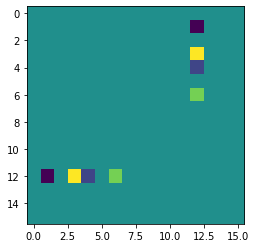

In [24]:
plt.imshow(H_laser_x_1.real)

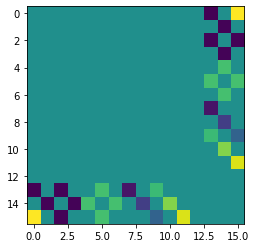

In [25]:
plt.imshow(H_laser_x_2.real)

In [26]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 16.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.71it/s]


In [27]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z
Px2 = Function("Px2")(t) # Polarization switching function for x
Pz2 = Function("Pz2")(t) # Polarization switching function for z

laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1), 
                (H_laser_z_2*Pz2, ME_main_2), (H_laser_x_2*Px2, ME_main_2)]
detunings = [[QN.index(excited_states[0])], [QN.index(excited_states[idx]) for idx in [1,2,3]]]

In [70]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [71]:
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωs[0][0]).subs(Ωs[1][1],Ωs[0][1])
H_symbolic = H_symbolic.subs(Ωs[2][0],Ωs[1][0]).subs(Ωs[2][1],Ωs[1][1])
H_symbolic = H_symbolic.subs(Ωs[3][0],Ωs[1][0]).subs(Ωs[3][1],Ωs[1][1])

In [72]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.04it/s]


In [73]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [74]:
from julia import Main

In [75]:
Main.using("DifferentialEquations")
Main.using("BenchmarkTools")
Main.using("Trapz")
Main.using("LinearAlgebra")

# add sine_wave function and gaussian_2d function
Main.include("utils/general_ode_functions.jl")

<PyCall.jlwrap gaussian_2d>

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [90]:
ode_fun = """
function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩ1 = p[1]
\t\tνp1 = p[2]
\t\tΔ1 = p[3]
\t\tΩ2 = p[4]
\t\tνp2 = p[5]
\t\tΔ2 = p[6]
\t\tΩ1ᶜ = conj(Ω1)
\t\tΩ2ᶜ = conj(Ω2)
\t\tPx1 = sine_wave(t, νp1, 4.71238898038469)
\t\tPz1 = sine_wave(t, νp1, 1.5707963267948966)
\t\tPx2 = sine_wave(t, νp2, 4.71238898038469)
\t\tPz2 = sine_wave(t, νp2, 1.5707963267948966)
\t\tPx1 /= sqrt(Px1^2+Pz1^2)
\t\tPz1 /= sqrt(Px1^2+Pz1^2)
\t\tPx2 /= sqrt(Px2^2+Pz2^2)
\t\tPz2 /= sqrt(Px2^2+Pz2^2)
"""

In [91]:
print(ode_fun)


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω1 = p[1]
		νp1 = p[2]
		Δ1 = p[3]
		Ω2 = p[4]
		νp2 = p[5]
		Δ2 = p[6]
		Ω1ᶜ = conj(Ω1)
		Ω2ᶜ = conj(Ω2)
		Px1 = sine_wave(t, νp1, 4.71238898038469)
		Pz1 = sine_wave(t, νp1, 1.5707963267948966)
		Px2 = sine_wave(t, νp2, 4.71238898038469)
		Pz2 = sine_wave(t, νp2, 1.5707963267948966)
		Px1 /= sqrt(Px1^2+Pz1^2)
		Pz1 /= sqrt(Px1^2+Pz1^2)
		Px2 /= sqrt(Px2^2+Pz2^2)
		Pz2 /= sqrt(Px2^2+Pz2^2)



In [92]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [93]:
with open('ode_amherst_cyling.jl', 'w', encoding='utf8') as f:
    f.write(ode_fun)

In [94]:
# reading from file
with open('ode_amherst_cyling.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [95]:
# making the function in Julia
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

In [96]:
ρ_ini = np.zeros([n_states, n_states], dtype = complex)
np.fill_diagonal(ρ_ini[:n_states-4, :n_states-4], 1/(n_states-4))

In [97]:
Γ = 2*np.pi * 1.56e6
Ω1 =  1*Γ
Ω2 = 0*Γ
ωp1 = 2*np.pi*2e6 # 2 MHz
νp1 = ωp1/(2*np.pi)
ωp2 = 2*np.pi*2e6 # 2 MHz
νp2 = ωp2/(2*np.pi)
Δ1 = 0
Δ2 = 0
ω1 = 0
ω2 = 0

Main.Γ = Γ
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ1 = Δ1
Main.Ω2 = Ω2
Main.νp2 = νp2
Main.Δ2 = Δ2

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω1, νp1, Δ1, Ω2, νp2, Δ2]")

array([9801769.07920015, 2000000.        ,       0.        ,
             0.        , 2000000.        ,       0.        ])

In [98]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 4.16 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [99]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [100]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 2.5e-7, reltol = 2.4e-4, dt = 1e-9)
tmp = 0
""");

Wall time: 1.11 s


0

In [101]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

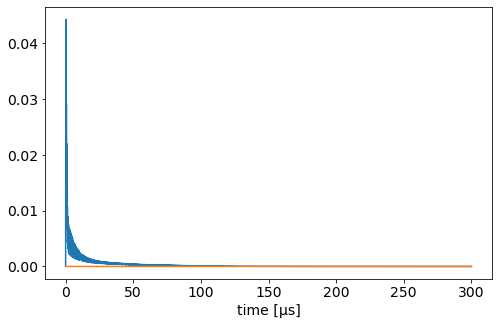

In [102]:
exc_F0 = pop_results[-4,:]
exc_F1 = np.sum(pop_results[-3:,:], axis = 0)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, exc_F0)
ax.plot(t_array, exc_F1)

ax.set_xlabel('time [μs]')

set_fontsize(ax, 14)

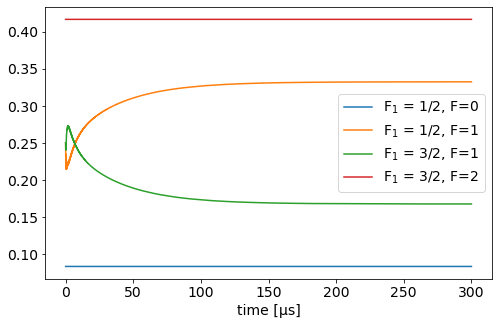

In [103]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, pop_results[0,:], label = r'F$_1$ = 1/2, F=0')
ax.plot(t_array, np.sum(pop_results[1:4,:], axis = 0), label = r'F$_1$ = 1/2, F=1')
ax.plot(t_array, np.sum(pop_results[4:7,:], axis = 0), label = r'F$_1$ = 3/2, F=1')
ax.plot(t_array, np.sum(pop_results[7:12,:], axis = 0), label = r'F$_1$ = 3/2, F=2')

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

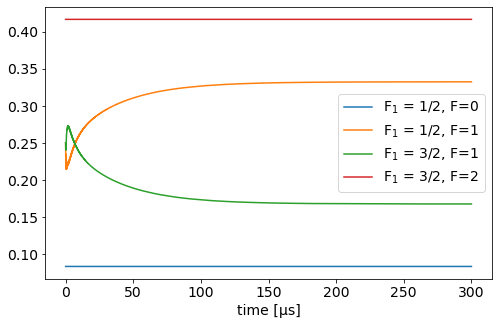

In [104]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, pop_results[0,:], label = r'F$_1$ = 1/2, F=0')
ax.plot(t_array, np.sum(pop_results[1:4,:], axis = 0), label = r'F$_1$ = 1/2, F=1')
ax.plot(t_array, np.sum(pop_results[4:7,:], axis = 0), label = r'F$_1$ = 3/2, F=1')
ax.plot(t_array, np.sum(pop_results[7:12,:], axis = 0), label = r'F$_1$ = 3/2, F=2')

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

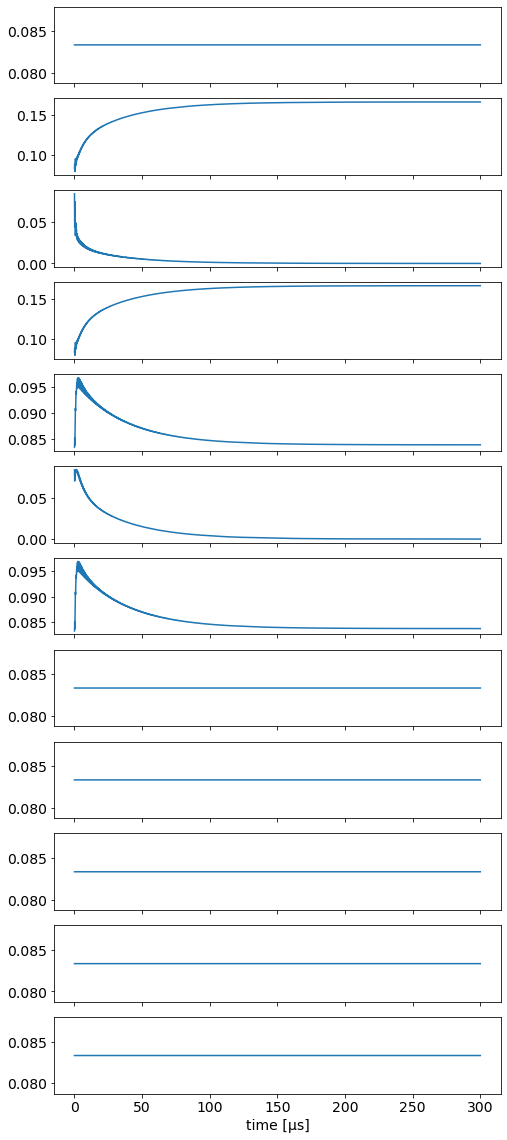

In [105]:
fig, axes = plt.subplots(figsize = (8,20), nrows = 12, sharex = True)
for idx, pop in enumerate(pop_results[:-4]):
    axes[idx].plot(t_array, pop)

axes[idx].set_xlabel('time [μs]')
for ax in axes:
    set_fontsize(ax, 14)